# Build and Train Decision Trees for Time-Dependent Classification Problems
## Purpose
In this example, we aim to demonstrate how to:

- Build a decision trees for time-dependent classification problems using real-world airline data.
- Compare the efficiency of decision trees built on various subsets of the data, including:
    - An XGBoost classifier trained once on the first 4 weeks of data.
    - An XGBoost classifier trained on a sliding window of data to mimic a more dynamic training regime, simulating real-world conditions where new data becomes available over time.
    - A Coreset Tree built incrementally using the CoresetTreeServiceDTC method, optimized for training speed and data efficiency. An XGBoost classifier is trained on a sliding window using the Coreset Tree.
- Evaluate and compare the performance of these models using a range of metrics such as balanced accuracy, F1 score, average precision, etc.
- Utilize various utility functions provided by the CoresetTreeServiceDTC class for operations such as building from file, partial building, fitting, grid_search and plotting.

- For the purpose of this notebook, we'll be using a dataset of flight information (https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGK). This dataset has been grouped into several CSV files, each representing a week's worth of flight data, including flight dates, delays, and other relevant attributes. The total dataset encompasses a full year's data, allowing us to simulate a real-world scenario where data accrues over time.

Our evaluation will focus on the performance of models over time, especially in terms of how they adapt to new data. The comparison will shed light on the advantages of using Coreset Trees versus traditional full dataset training methods, and how sliding window techniques can be applied to time-dependent data for predictive modelling. This approach aims to offer insights into efficient data utilization, model adaptability, and the trade-offs between model accuracy and computational efficiency.

In [27]:
import os
import time
import warnings
import zipfile
from pathlib import Path

import gdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image, display
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

from dataheroes import CoresetTreeServiceDTC

warnings.filterwarnings('ignore')

## Prepare the data, model, and parameters

### Flags and parameters

In [28]:
plot_tree_each_interation = False
print_stats_each_iteration = False
sliding_window = 4  # number of weeks to slide the window
full_dataset_trained_once = True
full_dataset_sliding_window = True
grid_search = True

#XGB model params for classification
clf_params = {
    'enable_categorical': True, 
    'learning_rate': 0.1, 
    'n_estimators': 1000, 
    'objective': 'binary:logistic'
}

# Grid search params
param_grid = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [1000,500],
    'objective': ['binary:logistic'],
    'enable_categorical': [True],
}

### Download and prepare the data

In [29]:
def unzip(zip_path: Path = Path("airlines.zip")):
    """Utility function used to unzip the airlines.zip file."""

    print("Unzipping files...")
    with zipfile.ZipFile(zip_path, "r") as zip_file:
        zip_file.extractall("data/Airlines/weekly_data_classification")

In [30]:
encoding = "ISO-8859-1"

# zip file link containing weekly data
zip_link = "https://drive.google.com/drive/folders/1dXjb2pePttTRVMCEUC25YROEUZYOibmp?usp=drive_link"

# create local data folder.
data_path = Path('data/Airlines/')
data_path.mkdir(parents=True, exist_ok=True)

# check if zip file exists
zip_file = data_path / 'airlines.zip'
if not zip_file.exists():
    # download the zip file
    gdown.download_folder(url=zip_link, output=str(data_path), quiet=False)
    # unzip the file
    unzip(zip_file)

# get files
data_path = data_path / 'weekly_data_classification'
csv_files = list(data_path.glob(f"*.csv"))
csv_files.sort()
print(f"Got {len(csv_files)} files")

Got 52 files


### Load the data

### Explore the data

In [31]:
df = pd.read_csv(csv_files[0], encoding=encoding)

In [32]:
df

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,...,Cancelled,Diverted,CRSElapsedTime,ActualElapsedTime,AirTime,Flights,Distance,DistanceGroup,DivAirportLandings,Delayed
0,2017,1,1,2,1,2017-01-02,AA,19805,AA,N788AA,...,0.0,0.0,402.0,417.0,362.0,1.0,2475.0,10,0.0,0
1,2017,1,1,2,1,2017-01-02,AA,19805,AA,N796AA,...,0.0,0.0,327.0,329.0,279.0,1.0,2475.0,10,0.0,0
2,2017,1,1,2,1,2017-01-02,AA,19805,AA,N790AA,...,0.0,0.0,328.0,313.0,277.0,1.0,2475.0,10,0.0,1
3,2017,1,1,2,1,2017-01-02,AA,19805,AA,N399AA,...,0.0,0.0,517.0,537.0,507.0,1.0,3784.0,11,0.0,0
4,2017,1,1,2,1,2017-01-02,AA,19805,AA,N4XBAA,...,0.0,0.0,63.0,122.0,36.0,1.0,175.0,1,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97686,2017,1,1,8,7,2017-01-08,WN,19393,WN,N8501V,...,0.0,0.0,115.0,101.0,82.0,1.0,577.0,3,0.0,0
97687,2017,1,1,8,7,2017-01-08,WN,19393,WN,N230WN,...,0.0,0.0,125.0,107.0,87.0,1.0,577.0,3,0.0,0
97688,2017,1,1,8,7,2017-01-08,WN,19393,WN,N280WN,...,0.0,0.0,245.0,205.0,186.0,1.0,1342.0,6,0.0,0
97689,2017,1,1,8,7,2017-01-08,WN,19393,WN,N237WN,...,0.0,0.0,225.0,207.0,190.0,1.0,1342.0,6,0.0,0


In [33]:
# store the start and end date of each week and print the average number of samples
week_statistics = dict()
avg_samples = 0
for week_no, csv_file in enumerate(csv_files):
    df = pd.read_csv(csv_file, encoding=encoding)
    avg_samples += len(df)
    week_statistics[week_no] = {
        'start_date': df['FlightDate'].min(),
        'end_date': df['FlightDate'].max(),
        'samples': len(df),
    }
    
avg_samples /= len(csv_files)
print(f"Average number of samples per file: {int(avg_samples)}")

Average number of samples per file: 107029


In [34]:
# create a dataframe from week_statistics, each row represents a week and i have 1 column with the numer of samples for each week
week_statistics_df = pd.DataFrame(week_statistics).T
week_statistics_df

,start_date,end_date,samples
0,2017-01-02,2017-01-08,97691
1,2017-01-09,2017-01-15,98292
2,2017-01-16,2017-01-22,99728
3,2017-01-23,2017-01-29,100559
4,2017-01-30,2017-02-05,98984
5,2017-02-06,2017-02-12,97832
6,2017-02-13,2017-02-19,100232
7,2017-02-20,2017-02-26,104997
8,2017-02-27,2017-03-05,104791
9,2017-03-06,2017-03-12,108506


### Utility functions

In [35]:
def get_first_n_weeks(n):
    return csv_files[:n]

def evaluate_model(model, week_no):
    # Predict on the next week in the dataset
    print(f"Predicting on week {week_no + 1}, from {week_statistics[week_no]['start_date']} to {week_statistics[week_no]['end_date']}")
    test_ds = pd.read_csv(csv_files[week_no], encoding=encoding)
    # Convert categorical columns to 'category' dtype
    for col in test_ds.select_dtypes(include=['object']).columns:
        test_ds[col] = test_ds[col].astype('category')
    X_test = test_ds.drop(columns=['Delayed'])
    y_test = test_ds['Delayed']
    prediction = model.predict(X_test)
    prediction_proba = model.predict_proba(X_test)
    # compute scores
    balanced_acc = balanced_accuracy_score(y_test, prediction)
    f1 = f1_score(y_test, prediction, average='weighted')
    roc_auc = roc_auc_score(y_test, prediction_proba[:,1],average='weighted')
    auprc = average_precision_score(y_test, prediction_proba[:,1],average='weighted')
    log_loss_score = log_loss(y_test, prediction_proba[:,1])
    if print_stats_each_iteration:
        print(f"Balanced accuracy: {balanced_acc:.4f}")
        print(f"F1: {f1:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}")
        print(f"AUPRC: {auprc:.4f}")
        print(f"Log loss: {log_loss_score:.4f}")
        print('---------------------------------')
    return balanced_acc, f1, roc_auc, auprc, log_loss_score

## Train a model on the first 4 weeks and then iteratively build the model on the next week using the CoresetTreeServiceDTC

### Initialize the CoresetTreeServiceDTC

In [36]:
"""
data_params_clf is used to specify the target column, the sequence column, and the granularity of the sequence column.
- target: the target column to predict
- seq_column: the sequence column the CoresetTreeService will be using to chunk the data. It is a dictionary with the following keys:
    - name: the name of the sequence column
    - granularity: the granularity of the sequence column. Set to 'W' for weekly.
    - datetime_format: the datetime format of the sequence column
    - chunk_by: whether to chunk the data by the sequence column, set to True
"""

data_params_clf = {
        'target': {'name': 'Delayed'},
        'seq_column': {
            'name': 'FlightDate',
            'granularity': 'W',
            'datetime_format': '%Y-%m-%d',
            'chunk_by': True,
        },
    }

service_obj = CoresetTreeServiceDTC(
    optimized_for='training',
    coreset_size=0.05,
    data_params=data_params_clf,
    model_cls=XGBClassifier,
)

### Build and train the model

In [37]:
tree_stats = []
tree_build_times = []
tree_fit_times = []

for week_no in range(sliding_window, len(csv_files)):
    start_week = week_no - sliding_window
    end_week = week_no - 1
    build_start = time.time()
    if week_no == sliding_window:
        print(f"Building a Coreset Tree on weeks {start_week + 1} to {end_week + 1}, from {week_statistics[start_week]['start_date']} to {week_statistics[end_week]['end_date']}")
        service_obj.build_from_file(get_first_n_weeks(end_week + 1))
    else:
        print(f"Adding week {end_week + 1} to the Coreset Tree, from {week_statistics[end_week]['start_date']} to {week_statistics[end_week]['end_date']}")
        service_obj.partial_build_from_file(csv_files[end_week])
    tree_build_times.append(time.time() - build_start)
    if plot_tree_each_interation:
        tree_img = service_obj.plot()['training']
        display(Image(tree_img))
        plt.close()
    # Fit the tree on the last n weeks of data
    print(f"Fitting on weeks {start_week + 1} to {end_week + 1}, from {week_statistics[start_week]['start_date']} to {week_statistics[end_week]['end_date']}")
    fit_start = time.time()
    if grid_search:
        # Perform grid search, validate on the last week and train on the previous weeks
        train_start = week_statistics[start_week]['start_date']
        train_end = week_statistics[end_week - 1]['end_date']
        validate_start = week_statistics[end_week - 1]['end_date']
        validate_end = week_statistics[end_week]['end_date']
        result = service_obj.grid_search(
            param_grid=param_grid,
            validation_method='seq-dependent validation',
            seq_train_from=train_start,
            seq_train_to=train_end,
            seq_validate_from=validate_start,
            seq_validate_to=validate_end,
            scoring='average_precision',
        )
    else:
        service_obj.fit(seq_from=week_statistics[start_week]['start_date'], seq_to=week_statistics[end_week]['end_date'], **clf_params)
    tree_fit_times.append(time.time() - fit_start)
    # Compute scores
    balanced_acc, f1, roc_auc, auprc, log_loss_score = evaluate_model(service_obj, end_week + 1)
    # Append scores to lists
    tree_stats.append([balanced_acc, f1, roc_auc, auprc, log_loss_score])
print("Finished Coreset Tree benchmark")

Building a Coreset Tree on weeks 1 to 4, from 2017-01-02 to 2017-01-29
Fitting on weeks 1 to 4, from 2017-01-02 to 2017-01-29
Predicting on week 5, from 2017-01-30 to 2017-02-05
Adding week 5 to the Coreset Tree, from 2017-01-30 to 2017-02-05
Fitting on weeks 2 to 5, from 2017-01-09 to 2017-02-05
Predicting on week 6, from 2017-02-06 to 2017-02-12
Adding week 6 to the Coreset Tree, from 2017-02-06 to 2017-02-12
Fitting on weeks 3 to 6, from 2017-01-16 to 2017-02-12
Predicting on week 7, from 2017-02-13 to 2017-02-19
Adding week 7 to the Coreset Tree, from 2017-02-13 to 2017-02-19
Fitting on weeks 4 to 7, from 2017-01-23 to 2017-02-19
Predicting on week 8, from 2017-02-20 to 2017-02-26
Adding week 8 to the Coreset Tree, from 2017-02-20 to 2017-02-26
Fitting on weeks 5 to 8, from 2017-01-30 to 2017-02-26
Predicting on week 9, from 2017-02-27 to 2017-03-05
Adding week 9 to the Coreset Tree, from 2017-02-27 to 2017-03-05
Fitting on weeks 6 to 9, from 2017-02-06 to 2017-03-05
Predicting on 

## Train a model on the first weeks and then predict on the rest of the weeks

In [38]:
if full_dataset_trained_once:
    # join first weeks
    df = pd.concat([pd.read_csv(x, encoding=encoding) for x in csv_files[:sliding_window]])
    X = df.drop(columns=['Delayed'])
    # Convert categorical columns to 'category' dtype
    for col in X.select_dtypes(include=['object']).columns:
        X[col] = X[col].astype('category')
    y = df['Delayed']

    # train the model
    start = time.time()
    if grid_search:
        # train on the first n-1 weeks of the data and validate on the last week
        # Create a numpy array with -1 for the training set
        train_folds = np.full(sum(week_statistics[week_no]['samples'] for week_no in range(sliding_window - 1)), -1, dtype=int)
        
        # Create a numpy array with 0 for the validation set
        validation_folds = np.zeros(week_statistics[sliding_window - 1]['samples'], dtype=int)
        
        # Concatenate the training and validation arrays to create the test_fold array
        test_fold = np.concatenate([train_folds, validation_folds])

        cv_splitter = PredefinedSplit(test_fold)
        model = GridSearchCV(estimator = XGBClassifier(), param_grid = param_grid, scoring='average_precision',
                          cv = cv_splitter, n_jobs = -1)
    else:
        model = XGBClassifier(**clf_params)
    model.fit(X, y)
    # predict on the rest of the weeks
    full_model_stats = []
    for week_no in range(sliding_window, len(csv_files)):
        balanced_acc, f1, roc_auc, auprc, log_loss_score = evaluate_model(model, week_no)
        full_model_stats.append([balanced_acc, f1, roc_auc, auprc, log_loss_score])
    full_dataset_total_time = time.time() - start
    print("Finished full dataset trained once benchmark")

Predicting on week 5, from 2017-01-30 to 2017-02-05
Predicting on week 6, from 2017-02-06 to 2017-02-12
Predicting on week 7, from 2017-02-13 to 2017-02-19
Predicting on week 8, from 2017-02-20 to 2017-02-26
Predicting on week 9, from 2017-02-27 to 2017-03-05
Predicting on week 10, from 2017-03-06 to 2017-03-12
Predicting on week 11, from 2017-03-13 to 2017-03-19
Predicting on week 12, from 2017-03-20 to 2017-03-26
Predicting on week 13, from 2017-03-27 to 2017-04-02
Predicting on week 14, from 2017-04-03 to 2017-04-09
Predicting on week 15, from 2017-04-10 to 2017-04-16
Predicting on week 16, from 2017-04-17 to 2017-04-23
Predicting on week 17, from 2017-04-24 to 2017-04-30
Predicting on week 18, from 2017-05-01 to 2017-05-07
Predicting on week 19, from 2017-05-08 to 2017-05-14
Predicting on week 20, from 2017-05-15 to 2017-05-21
Predicting on week 21, from 2017-05-22 to 2017-05-28
Predicting on week 22, from 2017-05-29 to 2017-06-04
Predicting on week 23, from 2017-06-05 to 2017-06-1

## Train a model on sliding window and then predict on the next week

In [39]:
if full_dataset_sliding_window:
    sliding_model_stats = []
    sliding_model_total_fit_times = []
    for week_no in range(sliding_window, len(csv_files)):
        start_week = week_no - sliding_window
        end_week = week_no
        print(f"Training on weeks {start_week + 1} to {end_week}, from {week_statistics[start_week]['start_date']} to {week_statistics[end_week]['end_date']}")
        df = pd.concat([pd.read_csv(x, encoding=encoding) for x in csv_files[start_week:end_week]])
        # Convert categorical columns to 'category' dtype
        for col in df.select_dtypes(include=['object']).columns:
            df[col] = df[col].astype('category')
        X = df.drop(columns=['Delayed'])
        y = df['Delayed']
        if grid_search:
            # Prepare the train and validation indices
            num_samples_train = sum(week_statistics[i]['samples'] for i in range(start_week, end_week - 1))
            num_samples_val = week_statistics[end_week - 1]['samples']
            train_indices = np.full(num_samples_train, -1, dtype=int)  # Training samples
            test_indices = np.zeros(num_samples_val, dtype=int)  # Validation samples
            total = np.concatenate([train_indices, test_indices])
            cv_splitter = PredefinedSplit(total)

            model = GridSearchCV(estimator = XGBClassifier(), param_grid = param_grid, scoring='average_precision',
                          cv = cv_splitter, n_jobs = -1)
        else:
            model = XGBClassifier(**clf_params)
        fit_start = time.time()
        model.fit(X, y)
        sliding_model_total_fit_times.append(time.time() - fit_start)
        balanced_acc, f1, roc_auc, auprc, log_loss_score = evaluate_model(model, end_week)
        sliding_model_stats.append([balanced_acc, f1, roc_auc, auprc, log_loss_score])
    print("Finished dataset sliding window benchmark")

Training on weeks 1 to 4, from 2017-01-02 to 2017-02-05
Predicting on week 5, from 2017-01-30 to 2017-02-05
Training on weeks 2 to 5, from 2017-01-09 to 2017-02-12
Predicting on week 6, from 2017-02-06 to 2017-02-12
Training on weeks 3 to 6, from 2017-01-16 to 2017-02-19
Predicting on week 7, from 2017-02-13 to 2017-02-19
Training on weeks 4 to 7, from 2017-01-23 to 2017-02-26
Predicting on week 8, from 2017-02-20 to 2017-02-26
Training on weeks 5 to 8, from 2017-01-30 to 2017-03-05
Predicting on week 9, from 2017-02-27 to 2017-03-05
Training on weeks 6 to 9, from 2017-02-06 to 2017-03-12
Predicting on week 10, from 2017-03-06 to 2017-03-12
Training on weeks 7 to 10, from 2017-02-13 to 2017-03-19
Predicting on week 11, from 2017-03-13 to 2017-03-19
Training on weeks 8 to 11, from 2017-02-20 to 2017-03-26
Predicting on week 12, from 2017-03-20 to 2017-03-26
Training on weeks 9 to 12, from 2017-02-27 to 2017-04-02
Predicting on week 13, from 2017-03-27 to 2017-04-02
Training on weeks 10 

## Print time metrics

In [41]:
stats_dict = [
    {
        'method': 'Coreset sliding window',
        'average_balanced_accuracy': round(sum([x[0] for x in tree_stats]) / len(tree_stats), 4),
        'average_f1': round(sum([x[1] for x in tree_stats]) / len(tree_stats), 4),
        'average_roc_auc': round(sum([x[2] for x in tree_stats]) / len(tree_stats), 4),
        'average_auprc': round(sum([x[3] for x in tree_stats]) / len(tree_stats), 4),
        'average_log_loss': round(sum([x[4] for x in tree_stats]) / len(tree_stats), 4),
        'total_time_seconds': round(sum(tree_build_times) + sum(tree_fit_times), 1),
        'average_seconds_per_iteration': round((sum(tree_build_times) + sum(tree_fit_times)) / len(tree_build_times), 1),
    }
]
if full_dataset_sliding_window:
    stats_dict.append({
        'method': 'Full dataset sliding window',
        'average_balanced_accuracy': round(sum([x[0] for x in sliding_model_stats]) / len(sliding_model_stats), 4),
        'average_f1': round(sum([x[1] for x in sliding_model_stats]) / len(sliding_model_stats), 4),
        'average_roc_auc': round(sum([x[2] for x in sliding_model_stats]) / len(sliding_model_stats), 4),
        'average_auprc': round(sum([x[3] for x in sliding_model_stats]) / len(sliding_model_stats), 4),
        'average_log_loss': round(sum([x[4] for x in sliding_model_stats]) / len(sliding_model_stats), 4),
        'total_time_seconds': round(sum(sliding_model_total_fit_times), 1),
        'average_seconds_per_iteration': round(sum(sliding_model_total_fit_times) / len(sliding_model_total_fit_times), 1),
    })
if full_dataset_trained_once:
    stats_dict.append({
        'method': 'Full dataset trained once',
        'average_balanced_accuracy': round(sum([x[0] for x in full_model_stats]) / len(full_model_stats), 4),
        'average_f1': round(sum([x[1] for x in full_model_stats]) / len(full_model_stats), 4),
        'average_roc_auc': round(sum([x[2] for x in full_model_stats]) / len(full_model_stats), 4),
        'average_auprc': round(sum([x[3] for x in full_model_stats]) / len(full_model_stats), 4),
        'average_log_loss': round(sum([x[4] for x in full_model_stats]) / len(full_model_stats), 4),
        'total_time_seconds': round(full_dataset_total_time, 1),
        'average_seconds_per_iteration': 'N/A',
    })
df = pd.DataFrame(stats_dict)
df

,method,average_balanced_accuracy,average_f1,average_roc_auc,average_auprc,average_log_loss,total_time_seconds,average_seconds_per_iteration
0,Coreset sliding window,0.5701,0.7732,0.6899,0.3223,0.4621,683.9,14.2
1,Full dataset sliding window,0.5408,0.7783,0.6680,0.3168,0.4539,2453.4,51.1
2,Full dataset trained once,0.5712,0.7574,0.6420,0.2853,0.5403,103.9,N/A


## Plot performance metrics

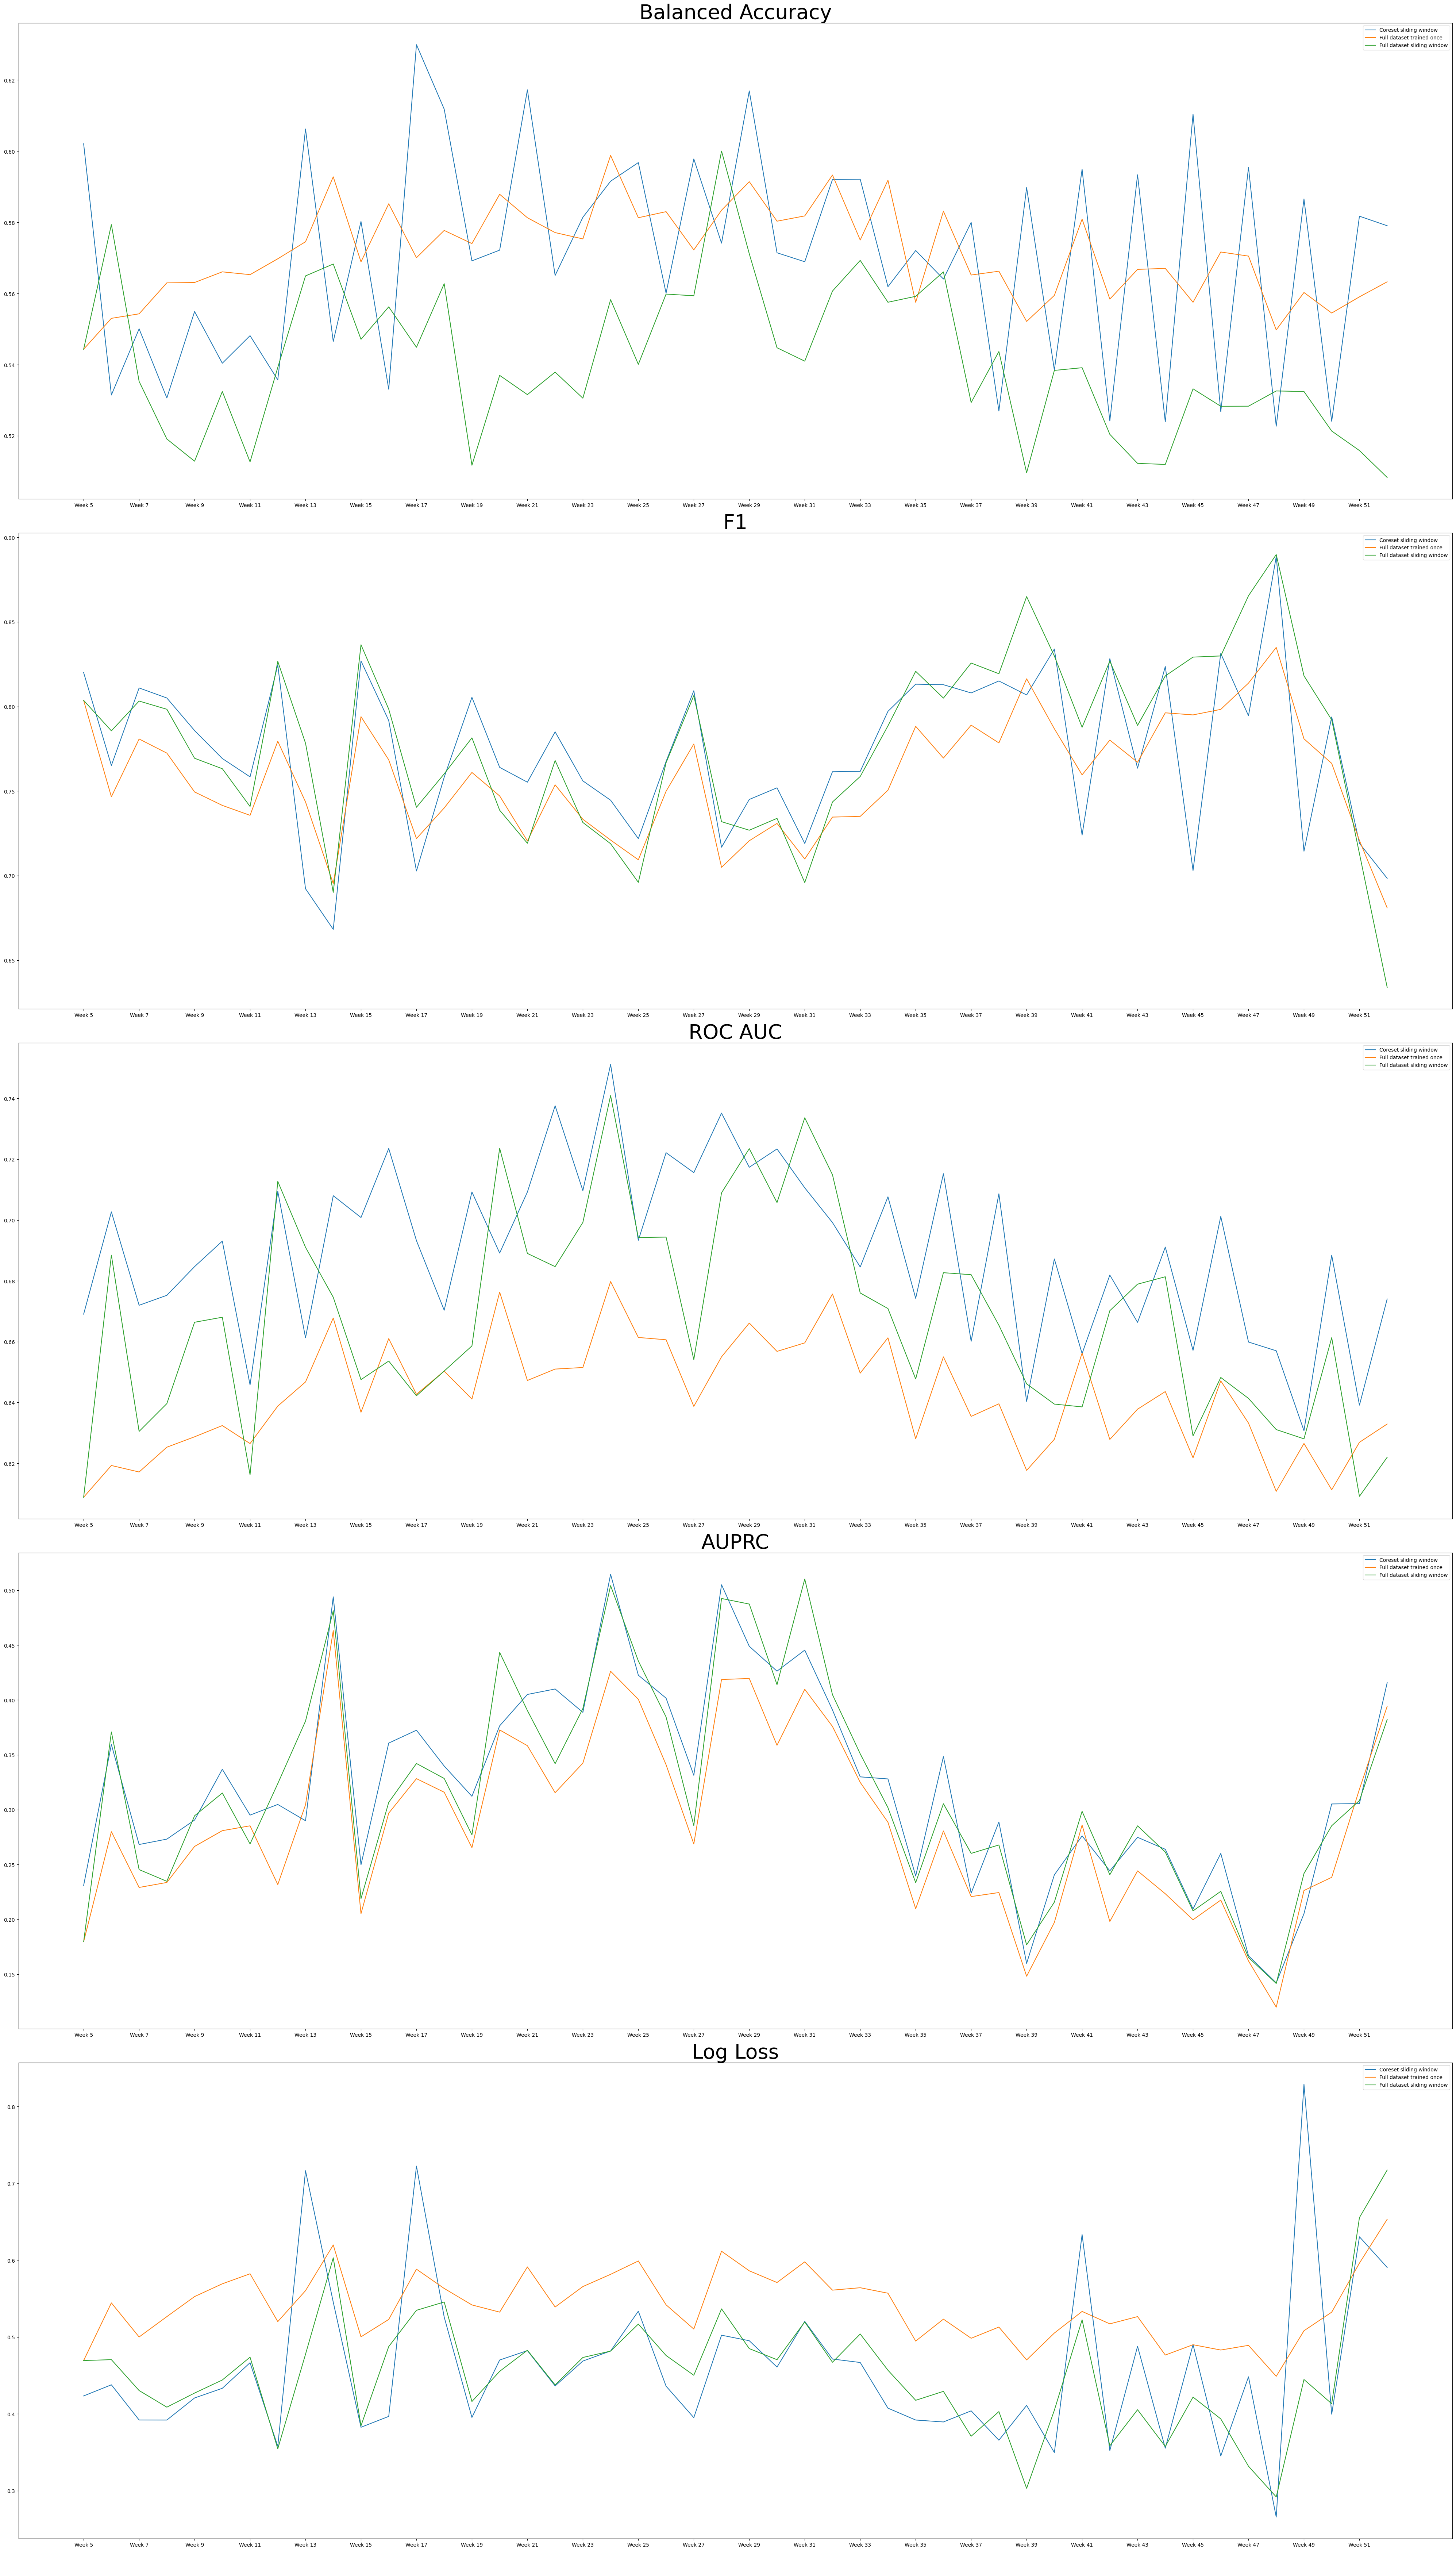

In [42]:
# plot the metrics
# set the x axis labels
x_labels = [f"Week {i + sliding_window + 1}" for i in range(len(tree_stats))]

# Define the titles for each metric
metric_titles = ['Balanced Accuracy', 'F1', 'ROC AUC', 'AUPRC', 'Log Loss']  # Add more titles if there are more metrics

# Create subplots for each metric
fig, axes = plt.subplots(len(metric_titles), 1, figsize=(40, 70))

for i, ax in enumerate(axes):
    # Plot the Coreset sliding window stats
    ax.plot(x_labels, [x[i] for x in tree_stats], label='Coreset sliding window')

    # Plot the full dataset trained once stats
    if full_dataset_trained_once:
        ax.plot(x_labels, [x[i] for x in full_model_stats], label='Full dataset trained once')

    # Plot the full dataset sliding window stats
    if full_dataset_sliding_window:
        ax.plot(x_labels, [x[i] for x in sliding_model_stats], label='Full dataset sliding window')

    # Set title, legend, and adjust ticks
    ax.set_title(metric_titles[i], fontsize=40)
    ax.legend()

    # Assuming locs and labels are the same for all plots, set ticks for the x-axis
    locs = ax.get_xticks()
    labels = ax.get_xticklabels()
    new_locs = locs[::2]  # Take every second element
    new_labels = [label.get_text() for label in labels][::2]  # Take every second label
    ax.set_xticks(new_locs)
    ax.set_xticklabels(new_labels)

plt.tight_layout()  # Adjust the layout
plt.show()